In [11]:
## Importar librerias
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

In [20]:
# Paso 1: Construcción de la lista de archivos
column_names = ['ch_acc_X', 'ch_acc_Y', 'ch_acc_Z','ecg_signal1', 'ecg_signal2','lf_ank_acc_X','lf_ank_acc_Y','lf_ank_acc_Z','lf_ank_gyr_X','lf_ank_gyr_Y','lf_ank_gyr_Z','lf_ank_mag_X','lf_ank_mag_Y','lf_ank_mag_Z','rt_lwr_arm_acc_X','rt_lwr_arm_acc_Y','rt_lwr_arm_acc_Z','rt_lwr_arm_gyr_X','rt_lwr_arm_gyr_Y','rt_lwr_arm_gyr_Z','rt_lwr_arm_mag_X','rt_lwr_arm_mag_Y','rt_lwr_arm_mag_Z','label']
subjects = ['mHealth_subject1','mHealth_subject2','mHealth_subject3','mHealth_subject4','mHealth_subject5','mHealth_subject6','mHealth_subject7','mHealth_subject8','mHealth_subject9','mHealth_subject_10']

In [32]:
##### Funciones #####
## Processar datos
def process_subjects(file_paths):
    # Inicializar DataFrame vacío para acumular datos del sujeto
    df_subjects = pd.DataFrame(columns=column_names)
    for subject in subjects:
        for file_path in file_paths:
            if subject in file_path: # Filtrar archivos del sujeto actual
                df_temp = pd.read_csv(file_path, sep="\t", header=None, names=column_names)
                df_subjects = pd.concat([df_subjects, df_temp], ignore_index=True)
                print(f'loaded {subject}')
    df_subjects.dropna(inplace=True)
    # print(f"Análisis del sujeto: {subject}")
    df_example = analyze_data(df_subjects, subject)
    return df_subjects

## Analizar datos
def analyze_data(df, file_name):
    # Paso 2: Leer y explorar los datos
    df_example = pd.read_csv(file_paths[0], sep="\t", header=None, names=column_names)
    print("Primeras 5 líneas del primer archivo:")
    display(df_example.head())

    # Paso 3: Limpieza de datos
    df_example.dropna(inplace=True)

    # Paso 4: Tipos de datos
    print("Tipos de datos de cada atributo:")
    # display(df_example.dtypes)
    display(df_example.dtypes.to_frame().rename(columns={0: 'Data Types'}))

    # Paso 5: Resumen estadístico
    print("Resumen estadístico:")
    display(df_example.describe())

    return df_example

## Generar distribución de clases
def generate_classdistribution(df):
    # Paso 6: Distribución de clases
    print(f"Distribución de clases")
    display(df.iloc[:, -1].value_counts())
    # print(df)
    display(df)
    # Paso 7: Correlación entre atributos
    print("Correlación entre atributos:")
    # print(df.corr())
    display(df.corr())

def generate_histogram(df):
    # Paso 8: Histograma de atributos
    plt.figure()
    df.hist(bins=50, figsize=(20,15))
    plt.title("Histograma")
    plt.show()

def generate_densitygraph(df):
    # Paso 9: Gráfica de densidad
    df.plot(kind='density', subplots=True, layout=(9,5), sharex=False, figsize=(20,15))
    plt.title("Gráfica de densidad")
    plt.show()

def generate_boxplot(df):
    # Paso 10: Gráfica de cajas y bigotes
    df.plot(kind='box', subplots=True, layout=(9,5), sharex=False, sharey=False, figsize=(20,15))
    plt.title("Gráfica de cajas y bigotes")
    plt.show()

def generate_corrmatrix(df):
    # Paso 11: Matriz de correlación
    corr = df.corr()
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.title("Matriz de correlación")
    plt.show()

def generate_scatterplot(df):
    # Paso 12: Matriz de dispersión
    pd.plotting.scatter_matrix(df, figsize=(20, 15))
    plt.title("Matriz de dispersión")
    plt.show()
    # return df

def normalize_data(df):
    # Paso 13: Escalado y normalización
    # scaler = StandardScaler()
    # df_scaled = scaler.fit_transform(df)
    # print(f"Datos escalados para {file_name} (primeras 5 filas):")
    # print(df_scaled[5])
    return df


In [23]:
## Ejecución
# directory_path = "datasets/mhealth"
directory_path = "/content/drive/MyDrive/RAHBFDP-2024_Proyecto/Datasets/mhealth"
file_paths = []

for subject in subjects:
        file_name = f'{subject}.log'
        file_path = os.path.join(directory_path, file_name)
        file_paths.append(file_path)

# Leemos
df_subjects = process_subjects(file_paths)

loaded mHealth_subject1
loaded mHealth_subject2
loaded mHealth_subject3
loaded mHealth_subject4
loaded mHealth_subject5
loaded mHealth_subject6
loaded mHealth_subject7
loaded mHealth_subject8
loaded mHealth_subject9
loaded mHealth_subject_10
Primeras 5 líneas del primer archivo:


,ch_acc_X,ch_acc_Y,ch_acc_Z,ecg_signal1,ecg_signal2,lf_ank_acc_X,lf_ank_acc_Y,lf_ank_acc_Z,lf_ank_gyr_X,lf_ank_gyr_Y,...,rt_lwr_arm_acc_X,rt_lwr_arm_acc_Y,rt_lwr_arm_acc_Z,rt_lwr_arm_gyr_X,rt_lwr_arm_gyr_Y,rt_lwr_arm_gyr_Z,rt_lwr_arm_mag_X,rt_lwr_arm_mag_Y,rt_lwr_arm_mag_Z,label
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-8.6499,-4.5781,0.187760,-0.44902,-1.0103,0.034483,-2.35000,-1.610200,-0.030899,0
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-8.6275,-4.3198,0.023595,-0.44902,-1.0103,0.034483,-2.16320,-0.882540,0.326570,0
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-8.5055,-4.2772,0.275720,-0.44902,-1.0103,0.034483,-1.61750,-0.165620,-0.030693,0
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-8.6279,-4.3163,0.367520,-0.45686,-1.0082,0.025862,-1.07710,0.006945,-0.382620,0
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-8.7008,-4.1459,0.407290,-0.45686,-1.0082,0.025862,-0.53684,0.175900,-1.095500,0


Tipos de datos de cada atributo:


,Data Types
ch_acc_X,float64
ch_acc_Y,float64
ch_acc_Z,float64
ecg_signal1,float64
ecg_signal2,float64
lf_ank_acc_X,float64
lf_ank_acc_Y,float64
lf_ank_acc_Z,float64
lf_ank_gyr_X,float64
lf_ank_gyr_Y,float64


Resumen estadístico:


,ch_acc_X,ch_acc_Y,ch_acc_Z,ecg_signal1,ecg_signal2,lf_ank_acc_X,lf_ank_acc_Y,lf_ank_acc_Z,lf_ank_gyr_X,lf_ank_gyr_Y,...,rt_lwr_arm_acc_X,rt_lwr_arm_acc_Y,rt_lwr_arm_acc_Z,rt_lwr_arm_gyr_X,rt_lwr_arm_gyr_Y,rt_lwr_arm_gyr_Z,rt_lwr_arm_mag_X,rt_lwr_arm_mag_Y,rt_lwr_arm_mag_Z,label
count,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,...,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000,161280.000000
mean,-8.737671,0.186275,-0.645707,-0.007960,-0.035226,1.229914,-9.667029,-1.650613,0.010649,-0.663745,...,-4.178516,-4.873407,2.174713,-0.405350,-0.307315,0.312170,0.491517,0.550921,-0.231137,1.352356
std,3.806288,1.453274,3.740042,0.504334,0.643813,4.671081,4.064311,5.030605,0.495378,0.322115,...,4.316094,6.294977,3.620740,0.482499,0.657173,0.537174,26.486971,32.263002,62.555109,2.981766
min,-22.303000,-17.430000,-17.906000,-7.321800,-8.619600,-22.075000,-19.619000,-19.373000,-1.549200,-2.189500,...,-22.173000,-18.932000,-18.228000,-1.702000,-2.164300,-1.234900,-268.690000,-363.900000,-697.160000,0.000000
25%,-9.832900,-0.380692,-2.824350,-0.188380,-0.205130,0.095848,-10.066000,-3.288900,-0.372910,-0.848030,...,-6.267425,-9.271700,0.170480,-0.758820,-0.767970,-0.163790,-5.458975,-10.782000,-13.399000,0.000000
50%,-9.330700,0.252830,-0.316040,-0.025118,-0.025118,1.785900,-9.570500,-0.711750,-0.161410,-0.741090,...,-3.572100,-7.269950,1.478000,-0.505880,-0.587270,0.400860,0.362590,0.352170,-0.369920,0.000000
75%,-8.020800,0.770090,1.665425,0.154890,0.163270,2.643100,-9.025600,0.649125,0.500930,-0.596620,...,-1.819600,-0.063443,4.387400,-0.129410,0.223820,0.775860,6.048675,10.905250,12.793000,0.000000
max,18.960000,20.713000,24.084000,5.450500,8.519100,20.054000,21.161000,25.015000,1.870100,1.525300,...,19.565000,21.914000,25.194000,1.162700,1.556500,2.750000,212.270000,334.980000,629.950000,12.000000


In [24]:
# Paso 6 y 7: Distribución de clases y Correlacion
generate_classdistribution(df_subjects)

Distribución de clases


0     872550
1      30720
2      30720
3      30720
4      30720
9      30720
10     30720
11     30720
5      30720
7      29441
8      29337
6      28315
12     10342
Name: label, dtype: int64

,ch_acc_X,ch_acc_Y,ch_acc_Z,ecg_signal1,ecg_signal2,lf_ank_acc_X,lf_ank_acc_Y,lf_ank_acc_Z,lf_ank_gyr_X,lf_ank_gyr_Y,...,rt_lwr_arm_acc_X,rt_lwr_arm_acc_Y,rt_lwr_arm_acc_Z,rt_lwr_arm_gyr_X,rt_lwr_arm_gyr_Y,rt_lwr_arm_gyr_Z,rt_lwr_arm_mag_X,rt_lwr_arm_mag_Y,rt_lwr_arm_mag_Z,label
0,-9.8184,0.009971,0.29563,0.004186,0.004186,2.1849,-9.6967,0.63077,0.103900,-0.84053,...,-8.6499,-4.5781,0.187760,-0.449020,-1.01030,0.034483,-2.35000,-1.610200,-0.030899,0
1,-9.8489,0.524040,0.37348,0.004186,0.016745,2.3876,-9.5080,0.68389,0.085343,-0.83865,...,-8.6275,-4.3198,0.023595,-0.449020,-1.01030,0.034483,-2.16320,-0.882540,0.326570,0
2,-9.6602,0.181850,0.43742,0.016745,0.037677,2.4086,-9.5674,0.68113,0.085343,-0.83865,...,-8.5055,-4.2772,0.275720,-0.449020,-1.01030,0.034483,-1.61750,-0.165620,-0.030693,0
3,-9.6507,0.214220,0.24033,0.079540,0.117220,2.1814,-9.4301,0.55031,0.085343,-0.83865,...,-8.6279,-4.3163,0.367520,-0.456860,-1.00820,0.025862,-1.07710,0.006945,-0.382620,0
4,-9.7030,0.303890,0.31156,0.221870,0.205130,2.4173,-9.3889,0.71098,0.085343,-0.83865,...,-8.7008,-4.1459,0.407290,-0.456860,-1.00820,0.025862,-0.53684,0.175900,-1.095500,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1215740,-9.2476,-0.248070,-2.62230,0.230250,0.234430,1.7849,-9.8287,0.29725,-0.341370,-0.90056,...,-3.7198,-8.9071,0.294230,0.041176,-0.99384,-0.480600,2.40890,7.496100,7.915500,0
1215741,-9.4632,-0.073513,-2.11190,0.276300,0.284670,1.8687,-9.8766,0.46236,-0.341370,-0.90056,...,-3.7160,-8.7455,0.448140,0.041176,-0.99384,-0.480600,1.69450,7.866000,7.897500,0
1215742,-9.4011,-0.144580,-3.02350,0.288850,0.301410,1.6928,-9.9290,0.16631,-0.341370,-0.90056,...,-3.8824,-9.1155,0.450480,0.041176,-0.99384,-0.480600,1.15770,8.052800,7.884900,0
1215743,-9.3732,-0.026252,-2.70760,0.351650,0.347460,1.5279,-9.6306,0.30458,-0.341370,-0.90056,...,-3.5564,-9.1441,0.594880,0.041176,-0.99384,-0.480600,0.27441,9.487900,5.325800,0


Correlación entre atributos:


<ipython-input-22-d3f81b9cea2d>:48: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  display(df.corr())


,ch_acc_X,ch_acc_Y,ch_acc_Z,ecg_signal1,ecg_signal2,lf_ank_acc_X,lf_ank_acc_Y,lf_ank_acc_Z,lf_ank_gyr_X,lf_ank_gyr_Y,...,lf_ank_mag_Z,rt_lwr_arm_acc_X,rt_lwr_arm_acc_Y,rt_lwr_arm_acc_Z,rt_lwr_arm_gyr_X,rt_lwr_arm_gyr_Y,rt_lwr_arm_gyr_Z,rt_lwr_arm_mag_X,rt_lwr_arm_mag_Y,rt_lwr_arm_mag_Z
ch_acc_X,1.000000,0.075047,0.177665,0.023738,-0.002557,0.049533,0.306326,0.102474,0.042825,0.248209,...,-0.031728,0.265554,0.192660,0.006852,0.064624,0.129873,0.072662,0.010131,0.012216,0.002987
ch_acc_Y,0.075047,1.000000,-0.347484,0.026654,0.006867,-0.028290,-0.091808,-0.099557,-0.037858,-0.119972,...,0.034639,0.060447,-0.045245,-0.027285,0.040271,-0.148965,-0.011235,-0.043702,-0.058541,0.123086
ch_acc_Z,0.177665,-0.347484,1.000000,-0.009654,-0.009729,0.089834,0.229559,0.234645,0.048494,0.250113,...,-0.040221,-0.071137,0.308582,0.003834,-0.063382,0.333775,0.002792,-0.006107,-0.015756,0.029140
ecg_signal1,0.023738,0.026654,-0.009654,1.000000,0.596522,0.004474,0.002673,0.000312,-0.002104,0.010112,...,0.008074,-0.006348,-0.015570,0.012607,0.013202,-0.024703,-0.001834,0.010237,-0.018949,0.021411
ecg_signal2,-0.002557,0.006867,-0.009729,0.596522,1.000000,-0.002336,-0.005057,0.000327,0.012728,0.005582,...,0.000225,-0.010993,-0.028891,0.021917,0.022226,-0.033284,-0.003162,0.009626,-0.005878,0.003344
lf_ank_acc_X,0.049533,-0.028290,0.089834,0.004474,-0.002336,1.000000,0.017623,-0.071447,0.062249,0.086861,...,0.042373,-0.051124,0.060467,-0.003893,-0.025895,0.063999,0.016274,-0.010497,0.001437,0.004502
lf_ank_acc_Y,0.306326,-0.091808,0.229559,0.002673,-0.005057,0.017623,1.000000,0.077962,0.049371,0.350496,...,-0.026830,0.067072,0.105946,0.092445,0.049759,0.152128,0.105169,-0.049500,-0.060944,0.004695
lf_ank_acc_Z,0.102474,-0.099557,0.234645,0.000312,0.000327,-0.071447,0.077962,1.000000,0.029332,0.164673,...,0.120252,-0.124775,0.192842,0.086563,0.042051,0.076887,-0.004969,0.029342,0.013785,0.017542
lf_ank_gyr_X,0.042825,-0.037858,0.048494,-0.002104,0.012728,0.062249,0.049371,0.029332,1.000000,0.138167,...,0.044039,0.015465,-0.003553,0.058735,0.368314,0.027308,0.591376,0.020086,0.026516,-0.030014
lf_ank_gyr_Y,0.248209,-0.119972,0.250113,0.010112,0.005582,0.086861,0.350496,0.164673,0.138167,1.000000,...,0.023185,-0.079234,0.139140,0.082565,0.106395,0.204324,0.124094,-0.055375,-0.039157,0.065385


In [ ]:
# Paso 8: Histograma de atributos
generate_histogram(df_subjects)

In [ ]:
# Paso 9: Gráfica de densidad
generate_densitygraph(df_subjects)

In [ ]:
# Paso 10: Gráfica de cajas y bigotes
generate_boxplot(df_subjects)

<ipython-input-22-d3f81b9cea2d>:71: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


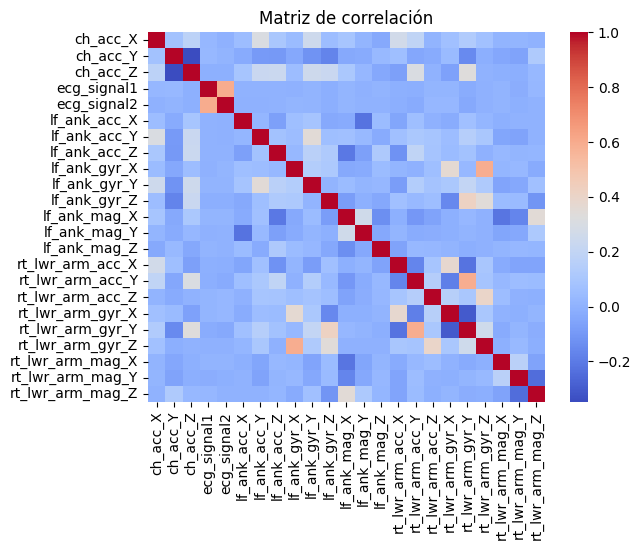

In [29]:
# Paso 11: Matriz de correlación
generate_corrmatrix(df_subjects)

In [ ]:
# Paso 12: Matriz de dispersión
generate_scatterplot(df_subjects)

In [ ]:
# Paso 13: Escalado y normalización
normalize_data(df_subjects)
